In [1]:
from M1M3tools import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import glob
import pandas as pd

%matplotlib inline
plt.jet()

import scipy.io

<Figure size 432x288 with 0 Axes>

In [2]:
# available in mat: 'Udn3norm','Vdn3norm','Gdn','x','y','dnx','dny','dnz'
mat = scipy.io.loadmat('data/myUdn3norm_156.mat')
Udn3norm = mat['Udn3norm']
Vdn3norm = mat['Vdn3norm']
bx = mat['x']
by = mat['y']
nodeID = mat['annulus']
X = np.loadtxt('data/LSST_BM_XTalk.txt')

### We want to keep our mode shapes orthonormal, so we keep shapes unchanged, and scale the forces


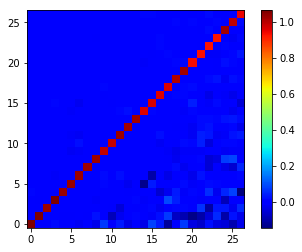

In [3]:
plt.imshow(X, origin='lower')
plt.colorbar()

What the cross talk matrix means, is, mathematically,

$
\left[ \begin{array}{c} m1  \\ m2 \\ \vdots \\ m27 \end{array} \right]
= X^T
\left[ \begin{array}{c} U1  \\ U2 \\ \vdots \\ U27 \end{array} \right]
= X^T G
\left[ \begin{array}{c} V1  \\ V2 \\ \vdots \\ V27 \end{array} \right]
$

m1, m2, ..., m27 are measured mode shapes. U1, U2, ..., U27 are FEA mode shapes. These are all matrix blocks, each is a nNode x 1 vector. nNode is the number of surface nodes. 

V1, V2, ..., V27 are FEA force sets. These are matrix blocks too, each being a 156 x 1 vector. G is the FEA influence matrix, which is nNode x 156.

Noticing that when we applied V1, V2, ..., V27 forces in the Mirror Lab, we measured m1, m2, ..., m27. $X^T G$ actually gives us the real influence matrix ($g$).

$g = X^T G$

Now, what we want to derive is the force sets that would give us U1, U2, ..., U27 in the real world.

$
\left[ \begin{array}{c} f1  \\ f2 \\ \vdots \\ f27 \end{array} \right]
= g^{-1}
\left[ \begin{array}{c} U1  \\ U2 \\ \vdots \\ U27 \end{array} \right]
= g^{-1} G
\left[ \begin{array}{c} V1  \\ V2 \\ \vdots \\ V27 \end{array} \right]
= (X^T G)^{-1} G
\left[ \begin{array}{c} V1  \\ V2 \\ \vdots \\ V27 \end{array} \right]
$

So, the matrix we want is

$m = (X^T G)^{-1} G = (X^T)^{-1} $

Note that $G$ is a matrix that applies to the matrix blocks above. Each element of the 27x27 matrix $X^T$ is mutliplied with $G$. Therefore $G$ is commutable with $X$.

In [4]:
from numpy.linalg import inv
m=inv(X.transpose())

Text(0.5, 1.0, '$X^T (X^T)^{-1}$')

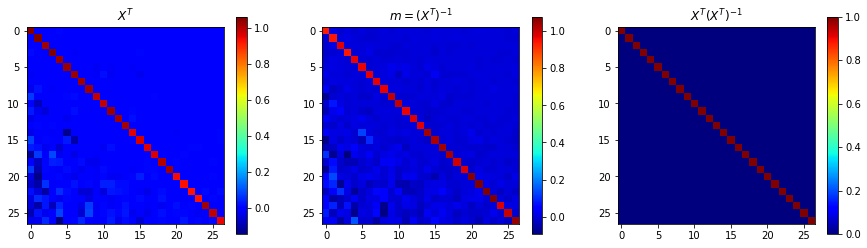

In [5]:
#check to make sure the matrix inversion is good
fig, ax = plt.subplots(1,3, figsize=(15,4))
img=ax[0].imshow(X.transpose())
fig.colorbar(img, ax=ax[0])
ax[0].set_title('$X^T$')
img=ax[1].imshow((m))
fig.colorbar(img, ax=ax[1])
ax[1].set_title('$m = (X^T)^{-1}$')
img=ax[2].imshow(X.transpose().dot(m))
fig.colorbar(img, ax=ax[2])
ax[2].set_title('$X^T (X^T)^{-1}$')

In [7]:
#mode shapes are same as FEA
aa = np.hstack([nodeID, bx, by, Udn3norm])
np.savetxt('data/M1M3_1um_156_grid.txt', aa, fmt = '%.6e')

In [12]:
# if we take into accout the XTalk to come up with new forces.
fx = Vdn3norm.copy() # we will leave forces for mode 28 and up untouched.
fx[:, :27] = 0
for i in range(27):
    for j in range(27):
        fx[:,i] = fx[:, i]+m[i,j]*Vdn3norm[:,j]

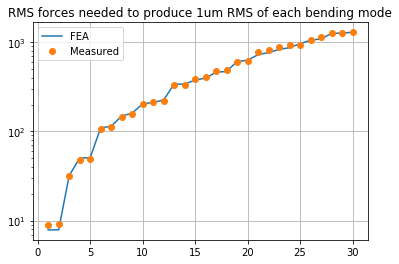

In [13]:
#check that we didn't seriously mess up
plt.semilogy(range(1,31), np.std(Vdn3norm[:,:30], axis=0), label='FEA')
plt.semilogy(range(1,31), np.std(fx[:,:30], axis=0),'o', label='Measured')
plt.title('RMS forces needed to produce 1um RMS of each bending mode')
plt.grid()
plt.legend()

### check the orientation of the astigmatisms, forces vs. shape

/Processed/190213_4-6 (Labeled as 3-7)/Combined/Combined M1M3 Map Mode number-1.h5: date not in h5 file. 
/Processed/190213_4-6 (Labeled as 3-7)/Combined/Combined M1M3 Map Mode number-1.h5: date not in h5 file. 


Text(0.5, 1.0, 'Measured forces')

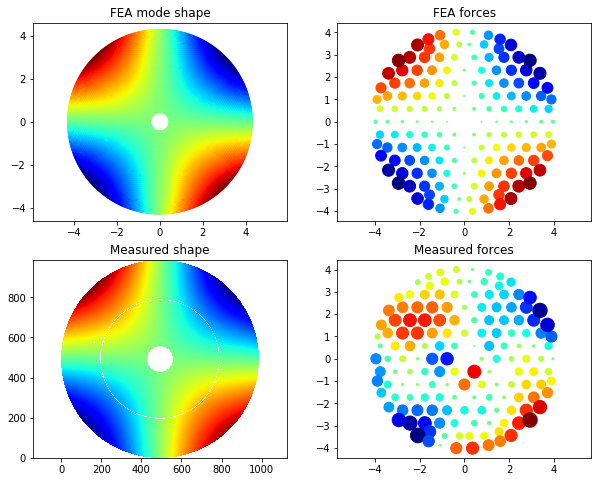

In [11]:
#get the measured mode shape
dateID = 190213
testID = '4-6'
testID1 = '3-7'
modeID = 1
iter = ' (Labeled as 3-7)'
fileset = sorted(glob.glob('%s/Processed/%d_%s%s/Combined/Combined*-%d.h5'%(
    dataDir, dateID, testID, iter, modeID)))
m1s,centerRow1,centerCol1,pixelSize1 = readH5Map(fileset, '/M1Data')
m3s,centerRow3,centerCol3,pixelSize3 = readH5Map(fileset, '/M3Data')
[x1, y1] = mkXYGrid(m1s, centerRow1, centerCol1, pixelSize1)
[x3, y3] = mkXYGrid(m3s, centerRow3, centerCol3, pixelSize3)
s = mkM1M3disp(m1s, m3s, x1, y1, x3, y3)
    
fig, ax = plt.subplots(2,2, figsize=(10,8))
img = ax[0][0].scatter(np.squeeze(bx), np.squeeze(by), c=-Udn3norm[:,0])
img = ax[0][1].scatter(xact, yact, abs(Vdn3norm[:,0])*10, -Vdn3norm[:,0])
img = ax[1][0].imshow(s, origin='lower')
img = ax[1][1].scatter(xact, yact, abs(fx[:,0])*10, -fx[:,0])
ax[0][0].axis('equal')
ax[0][1].axis('equal')
ax[1][0].axis('equal')
ax[1][1].axis('equal')
ax[0][0].set_title('FEA mode shape')
ax[0][1].set_title('FEA forces')
ax[1][0].set_title('Measured shape')
ax[1][1].set_title('Measured forces')

## We will ignore the cross-talk terms in coming up with final force sets for the bending modes. The cross-talk terms look more like noise, instead of real cross talk.

In [16]:
m=inv(np.diag(np.diag(X)))
f = Vdn3norm.copy() # we will leave forces for mode 28 and up untouched.
f[:, :27] = 0
for i in range(27):
    for j in range(27):
        f[:,i] = f[:, i]+m[i,j]*Vdn3norm[:,j]

### check the orientation of the astigmatisms, forces vs. shape

/Processed/190213_4-6 (Labeled as 3-7)/Combined/Combined M1M3 Map Mode number-1.h5: date not in h5 file. 
/Processed/190213_4-6 (Labeled as 3-7)/Combined/Combined M1M3 Map Mode number-1.h5: date not in h5 file. 


Text(0.5, 1.0, 'Measured forces')

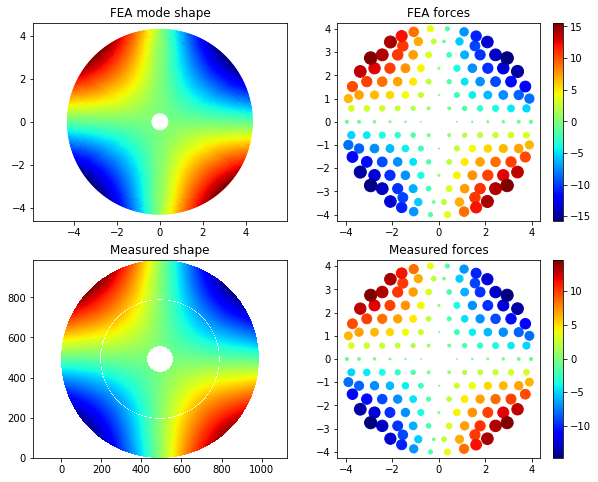

In [22]:
#get the measured mode shape
dateID = 190213
testID = '4-6'
testID1 = '3-7'
modeID = 1
iter = ' (Labeled as 3-7)'
fileset = sorted(glob.glob('%s/Processed/%d_%s%s/Combined/Combined*-%d.h5'%(
    dataDir, dateID, testID, iter, modeID)))
m1s,centerRow1,centerCol1,pixelSize1 = readH5Map(fileset, '/M1Data')
m3s,centerRow3,centerCol3,pixelSize3 = readH5Map(fileset, '/M3Data')
[x1, y1] = mkXYGrid(m1s, centerRow1, centerCol1, pixelSize1)
[x3, y3] = mkXYGrid(m3s, centerRow3, centerCol3, pixelSize3)
s = mkM1M3disp(m1s, m3s, x1, y1, x3, y3)
    
fig, ax = plt.subplots(2,2, figsize=(10,8))
img = ax[0][0].scatter(np.squeeze(bx), np.squeeze(by), c=-Udn3norm[:,0])
img = ax[0][1].scatter(xact, yact, abs(Vdn3norm[:,0])*10, -Vdn3norm[:,0])
fig.colorbar(img, ax=ax[0][1])
img = ax[1][0].imshow(s, origin='lower')
img = ax[1][1].scatter(xact, yact, abs(f[:,0])*10, -f[:,0])
fig.colorbar(img, ax=ax[1][1])
ax[0][0].axis('equal')
ax[0][1].axis('equal')
ax[1][0].axis('equal')
ax[1][1].axis('equal')
ax[0][0].set_title('FEA mode shape')
ax[0][1].set_title('FEA forces')
ax[1][0].set_title('Measured shape')
ax[1][1].set_title('Measured forces')

In [20]:
aa = np.hstack([actID.reshape(-1,1), xact.reshape(-1,1), yact.reshape(-1,1), f])
np.savetxt('data/M1M3_1um_156_force.txt', aa, fmt = '%.6e')